This notebook will be used to clean the parser log dataset

In [ ]:
#loading the gdrive
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#loading the packages
!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet

     |████████████████████████████████| 24.2 MB 109.2 MB/s 
     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 497.9 MB 30 kB/s 
     |████████████████████████████████| 462 kB 69.6 MB/s 
     |████████████████████████████████| 5.8 MB 43.9 MB/s 
     |████████████████████████████████| 1.4 MB 48.6 MB/s 
     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 163 kB 39.5 MB/s 
     |████████████████████████████████| 7.6 MB 42.9 MB/s 


In [ ]:
#loading the packages
import pandas as pd
import numpy as np
import sys
import os
import re

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel


import sklearn as sk

import nltk
from nltk.data import find

import matplotlib.pyplot as plt



#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

In [ ]:
os.chdir('/content/gdrive/MyDrive/W266_Final_Project/Tbird parsed/')

In [ ]:
#downloading the BGL structured dataset
df=pd.read_csv('Thunderbird_20M.log_structured.csv')

In [ ]:
df.head()

,LineId,Label,Id,Date,Admin,Month,Day,Time,AdminAddr,Content,EventId,EventTemplate
0,1,-,1131523501,2005.11.09,aadmin1,Nov,10,00:05:01,src@aadmin1,in.tftpd[14620]: tftp: client does not accept ...,ba463c69,in.tftpd[<*>]: tftp: client does not accept op...
1,2,-,1131524071,2005.11.09,tbird-admin1,Nov,10,00:14:31,local@tbird-admin1,postfix/postdrop[10896]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...
2,3,-,1131524073,2005.11.09,tbird-admin1,Nov,10,00:14:33,local@tbird-admin1,postfix/postdrop[10900]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...
3,4,-,1131524106,2005.11.09,tbird-admin1,Nov,10,00:15:06,local@tbird-admin1,postfix/postdrop[10910]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...
4,5,-,1131524107,2005.11.09,tbird-admin1,Nov,10,00:15:07,local@tbird-admin1,postfix/postdrop[10913]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...


In [ ]:
import random
random.seed(43)
index = [i for i in range(df.shape[0])]
random.shuffle(index)
df.set_index([index]).sort_index()

,LineId,Label,Id,Date,Admin,Month,Day,Time,AdminAddr,Content,EventId,EventTemplate
0,13036061,-,1134479813,2005.12.13,bn278,Dec,13,05:16:53,bn278/bn278,Server Administrator: Instrumentation Service ...,5ffb1ca0,Server Administrator: Instrumentation Service ...
1,16050641,-,1135205877,2005.12.21,cn711,Dec,21,14:57:57,cn711/cn711,crond(pam_unix)[27418]: session opened for use...,8fbc6c52,<*> session opened for user <*> by <*>
2,810064,-,1131672216,2005.11.10,dn741,Nov,10,17:23:36,dn741/dn741,sysctl: net.ipv4.conf.default.accept_source_ro...,aafa8e92,sysctl: <*> = <*>
3,545813,-,1131671939,2005.11.10,cn812,Nov,10,17:18:59,cn812/cn812,kernel: Bootmem setup node 0 0000000000000000-...,f4024c62,kernel: <*> <*> node <*> <*>
4,15414050,-,1135088349,2005.12.20,bn201,Dec,20,06:19:09,bn201/bn201,Server Administrator: Instrumentation Service ...,5e3e6435,Server Administrator: Instrumentation Service ...
...,...,...,...,...,...,...,...,...,...,...,...,...
19999995,3558143,-,1132071240,2005.11.15,tbird-admin1,Nov,15,08:14:00,local@tbird-admin1,/apps/x86_64/system/ganglia-3.0.1/sbin/gmetad[...,e77fd980,/apps/x<*>_<*>/system/ganglia-<*>.<*>.<*>/sbin...
19999996,5792767,-,1132458394,2005.11.19,bn575,Nov,19,19:46:34,bn575/bn575,kernel: ACPI: PCI interrupt 0000:07:08.0[A] ->...,ef9a2247,kernel: ACPI: PCI interrupt <*> -> GSI <*> (le...
19999997,6115697,-,1132518230,2005.11.20,tbird-sm1,Nov,20,12:23:50,src@tbird-sm1,ib_sm.x[24904]: [ib_sm_discovery.c:1103]: Fail...,107fd39a,ib_sm.x[<*>]: [ib_sm_discovery.c:<*>]: Failed ...
19999998,15784583,-,1135162701,2005.12.21,dn1023,Dec,21,02:58:21,dn1023/dn1023,crond[3866]: (root) CMD (run-parts /etc/cron.h...,e818a5b5,crond[<*>]: (root) CMD <*> <*>


Cleaning the content, which has the log information in english language, we will clean the content off all the special characters, period etc.

In [ ]:
#copying the content file for cleaning purpose
df['Content1']=df['Content']

creating the label using the label column, the label is labelled as '-', we convert it into 0 for no events and 1 for severe events.

In [ ]:
df['Label1'] = df['Label'].map(lambda x: 0 if (x == '-') else 1) 
df.head()

,LineId,Label,Id,Date,Admin,Month,Day,Time,AdminAddr,Content,EventId,EventTemplate,Content1,Label1
0,1,-,1131523501,2005.11.09,aadmin1,Nov,10,00:05:01,src@aadmin1,in.tftpd[14620]: tftp: client does not accept ...,ba463c69,in.tftpd[<*>]: tftp: client does not accept op...,in.tftpd[14620]: tftp: client does not accept ...,0
1,2,-,1131524071,2005.11.09,tbird-admin1,Nov,10,00:14:31,local@tbird-admin1,postfix/postdrop[10896]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix/postdrop[10896]: warning: unable to lo...,0
2,3,-,1131524073,2005.11.09,tbird-admin1,Nov,10,00:14:33,local@tbird-admin1,postfix/postdrop[10900]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix/postdrop[10900]: warning: unable to lo...,0
3,4,-,1131524106,2005.11.09,tbird-admin1,Nov,10,00:15:06,local@tbird-admin1,postfix/postdrop[10910]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix/postdrop[10910]: warning: unable to lo...,0
4,5,-,1131524107,2005.11.09,tbird-admin1,Nov,10,00:15:07,local@tbird-admin1,postfix/postdrop[10913]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix/postdrop[10913]: warning: unable to lo...,0


In [ ]:
df.head()

,LineId,Label,Id,Date,Admin,Month,Day,Time,AdminAddr,Content,EventId,EventTemplate,Content1,Label1
0,1,-,1131523501,2005.11.09,aadmin1,Nov,10,00:05:01,src@aadmin1,in.tftpd[14620]: tftp: client does not accept ...,ba463c69,in.tftpd[<*>]: tftp: client does not accept op...,in.tftpd[14620]: tftp: client does not accept ...,0
1,2,-,1131524071,2005.11.09,tbird-admin1,Nov,10,00:14:31,local@tbird-admin1,postfix/postdrop[10896]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix/postdrop[10896]: warning: unable to lo...,0
2,3,-,1131524073,2005.11.09,tbird-admin1,Nov,10,00:14:33,local@tbird-admin1,postfix/postdrop[10900]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix/postdrop[10900]: warning: unable to lo...,0
3,4,-,1131524106,2005.11.09,tbird-admin1,Nov,10,00:15:06,local@tbird-admin1,postfix/postdrop[10910]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix/postdrop[10910]: warning: unable to lo...,0
4,5,-,1131524107,2005.11.09,tbird-admin1,Nov,10,00:15:07,local@tbird-admin1,postfix/postdrop[10913]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix/postdrop[10913]: warning: unable to lo...,0


Cleaining all the log content data of all the special characters

In [ ]:
df['Content1'].replace( { r'(0x)[0-9a-fA-F]+' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'\d+\.\d+\.\d+\.\d+' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'(?<=Warning: we failed to resolve data source name )[\w\s]+' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'\d+' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r':' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'|' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'=' : '' }, inplace= True, regex = True)


In [ ]:
df['Content1'].replace( { r'/' : ' ' }, inplace= True, regex = True)
df['Content1'].replace( { r'()' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'_' : ' ' }, inplace= True, regex = True)
df['Content1'].replace( { r',' : '' }, inplace= True, regex = True)

In [ ]:
df.head()

,LineId,Label,Id,Date,Admin,Month,Day,Time,AdminAddr,Content,EventId,EventTemplate,Content1,Label1
0,1,-,1131523501,2005.11.09,aadmin1,Nov,10,00:05:01,src@aadmin1,in.tftpd[14620]: tftp: client does not accept ...,ba463c69,in.tftpd[<*>]: tftp: client does not accept op...,in.tftpd[] tftp client does not accept options,0
1,2,-,1131524071,2005.11.09,tbird-admin1,Nov,10,00:14:31,local@tbird-admin1,postfix/postdrop[10896]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix postdrop[] warning unable to look up p...,0
2,3,-,1131524073,2005.11.09,tbird-admin1,Nov,10,00:14:33,local@tbird-admin1,postfix/postdrop[10900]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix postdrop[] warning unable to look up p...,0
3,4,-,1131524106,2005.11.09,tbird-admin1,Nov,10,00:15:06,local@tbird-admin1,postfix/postdrop[10910]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix postdrop[] warning unable to look up p...,0
4,5,-,1131524107,2005.11.09,tbird-admin1,Nov,10,00:15:07,local@tbird-admin1,postfix/postdrop[10913]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix postdrop[] warning unable to look up p...,0


Looking at the balance of the label parameter

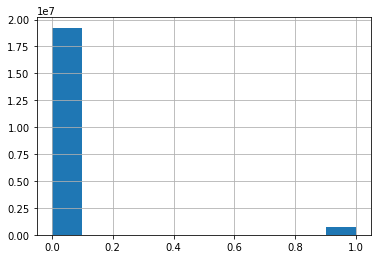

In [ ]:
df["Label1"].hist()

In [ ]:
df1=df.head(5000000)
df1.head()

,LineId,Label,Id,Date,Admin,Month,Day,Time,AdminAddr,Content,EventId,EventTemplate,Content1,Label1
0,1,-,1131523501,2005.11.09,aadmin1,Nov,10,00:05:01,src@aadmin1,in.tftpd[14620]: tftp: client does not accept ...,ba463c69,in.tftpd[<*>]: tftp: client does not accept op...,in.tftpd[] tftp client does not accept options,0
1,2,-,1131524071,2005.11.09,tbird-admin1,Nov,10,00:14:31,local@tbird-admin1,postfix/postdrop[10896]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix postdrop[] warning unable to look up p...,0
2,3,-,1131524073,2005.11.09,tbird-admin1,Nov,10,00:14:33,local@tbird-admin1,postfix/postdrop[10900]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix postdrop[] warning unable to look up p...,0
3,4,-,1131524106,2005.11.09,tbird-admin1,Nov,10,00:15:06,local@tbird-admin1,postfix/postdrop[10910]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix postdrop[] warning unable to look up p...,0
4,5,-,1131524107,2005.11.09,tbird-admin1,Nov,10,00:15:07,local@tbird-admin1,postfix/postdrop[10913]: warning: unable to lo...,85f57867,<*> warning: <*> <*> <*> <*> <*> No such file ...,postfix postdrop[] warning unable to look up p...,0


In [ ]:
df1['Label1'].value_counts()

0    4773905
1     226095
Name: Label1, dtype: int64

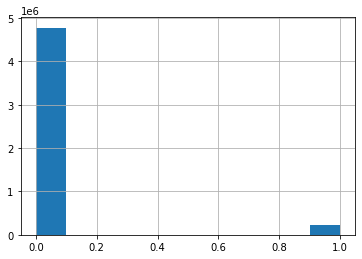

In [ ]:
df1['Label1'].hist()

Creating a smaller dataframe from the big database to be used for modelling

In [ ]:
df2 = df1[['Content1', 'Label1','EventId']].copy()

In [ ]:
df2.to_csv('clean_log.csv', encoding='utf-8')